# <a href="https://thetahat.ru/courses/bm-2025-spr">Машинное обучение ФБМФ</a>

## Семинар. Регуляризация на реальных данных.

В этом ноутбуке мы увидим, как регуляризация помогает бороться с мультиколлинеарностью на реальных [данных](https://genomebiology.biomedcentral.com/articles/10.1186/s13059-018-1599-6) экспрессии различных генов (RNA-seq) фибробласта человека.

In [2]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_percentage_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore')

sns.set_theme(font_scale=1)

## Введение


Биомаркеры старения — это измеримые показатели, которые отражают биологический возраст, в отличие от хронологического, и могут дать представление о состоянии здоровья человека, а также предсказать риск возрастных заболеваний. Транскриптомные данные (RNA-seq) являются мощным инструментом для идентификации таких биомаркеров, поскольку они позволяют зафиксировать динамику экспрессии генов, которая меняется с возрастом. RNA-seq предоставляет полное представление о транскриптоме, позволяя исследователям количественно оценить уровни экспрессии генов по всему геному. Анализируя данные RNA-seq от 133 человек в возрасте от 1 до 94 лет, исследование может выявить возрастные изменения в паттернах экспрессии генов, что поможет понять молекулярные основы старения и разработать новые подходы для оценки здоровья и профилактики возрастных заболеваний.

## 0. Подготовка данных

*Данные были получены при помощи РНК секвенирования, которое для каждого образца считает число молекул РНК (различные изоформы могут как учитываться, так и нет), экспрессированных с генов. Таким образом получается таблица, в которой представлены различные образцы по одной оси и названия генов по другой. На пересечении стоит число детектированных молекул, которое иногда называют каунтом.*

In [3]:
df = pd.read_csv("Rnaseq_age_reg.csv")
df.head()

,Age,NM-005483,NM-001286734,NM-080668,NM-001142557,NM-001258451,NM-007317,NM-005030,NM-002105,NM-001067,...,NM-001012507,NM-016448,NM-017669,NM-001160046,NM-004219,NM-001083961,NR-125339,NM-014501,NM-001278324,NM-005496
0,19,0.132011,-0.134300,0.451310,-0.022878,0.018667,0.093849,-0.052866,0.016490,0.124796,...,0.399409,0.603130,0.353623,-0.026512,0.214482,0.089629,-0.373683,-0.634992,0.150399,0.139014
1,19,0.547094,0.048433,0.616353,0.100657,0.449449,0.031947,-0.095406,0.002124,0.297503,...,-0.695090,1.047713,0.274719,-0.026406,-0.174677,0.188904,0.107204,-0.512265,-0.276802,-0.436953
2,19,-0.128915,0.058490,0.545019,0.011446,0.167808,0.193595,0.330663,0.269069,0.271928,...,-0.235994,0.249005,0.185740,-0.073686,0.207569,0.219520,0.104442,0.047305,-0.326697,-0.385664
3,19,0.108909,-0.304070,0.137853,-0.144723,0.454118,0.382229,0.331013,0.438284,0.265608,...,-0.249369,0.099310,0.012135,-0.379289,0.173875,0.458437,-0.295837,0.549386,0.482001,-0.341235
4,20,1.035609,0.878312,0.721720,0.760656,0.779344,0.948431,1.111776,0.548357,0.689128,...,0.781208,1.271952,0.471733,0.685357,1.142871,0.926903,0.571224,0.714480,0.811737,0.854124


Выделим независимые и зависимую переменные и разобьем датасет на train и test.

In [4]:
X, y = df.drop('Age', axis=1), df['Age']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, train_size=0.8, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((114, 164), (29, 164), (114,), (29,))

## 1. Что не так с методом наименьших квадратов?

Теперь попробуем аппроксимировать данные **линейной регрессией**. Обучим модель, посчитаем коэффициент детерминации [$R^2$](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.r2_score.html) и RMSE на тесте:

In [5]:
model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X = X_test)

print(f'R2: {round(r2_score(y_test, y_pred), 2)} \nMAPE: {round(mean_absolute_percentage_error(y_test, y_pred), 2)}')

R2: -0.22 
MAPE: 2.03


**Вывод**: $R^2$ отрицательный, а MAPE составляет 200%. Модель никуда не годится.

## 2. Как распознать мультиколлинеарность?

Быстрый ответ такой: если признаков очень много, скорее всего, они мультиколлинеарны. Но давайте копнём поглубже.

### 2.1 Число обусловленности

Число обусловленности (condition number) матрицы — это мера того, насколько чувствительно решение системы линейных уравнений $X\theta = y$ к изменениям в $y$ или в самой матрице $X$. Чем выше число обусловленности, тем больше может увеличиваться ошибка в решении при небольших изменениях в признаках и таргете.

> *Для прямоугольной матрицы $X$ оно равно корню из отношения наибольшего и наименьшего собственных чисел матрицы $X^TX$:*
$$
    κ(X) = \sqrt{\frac{\lambda_1}{\lambda_n}}
$$

Найдём число обусловленности нашей тренировочной матрицы:

In [6]:
np.linalg.cond(X_train)

518.7996040946947

**Вывод**

При наличии около линейных зависимостей вполне нормально иметь $\kappa$ порядка $10^3-10^6$ и даже больше. В нашем случае мультиколлинеарность, может быть, не столь сильна, но объективно есть.

### 2.1 Матрица корреляций

Построение матрицы корреляций позволяет количественно оценить вклад парных зависимостей между признаками.

> *Коэффициент корреляции &mdash; мера того, насколько хорошо точки ложатся на прямую. Чем он ближе к $\pm1$, тем выше "степень" линейной зависимости между двумя величинами, т. е. тем они сильнее коррелируют.*

Ниже приведён пример слабо и сильно коррелирующих индикаторов в тренировочной выборке.

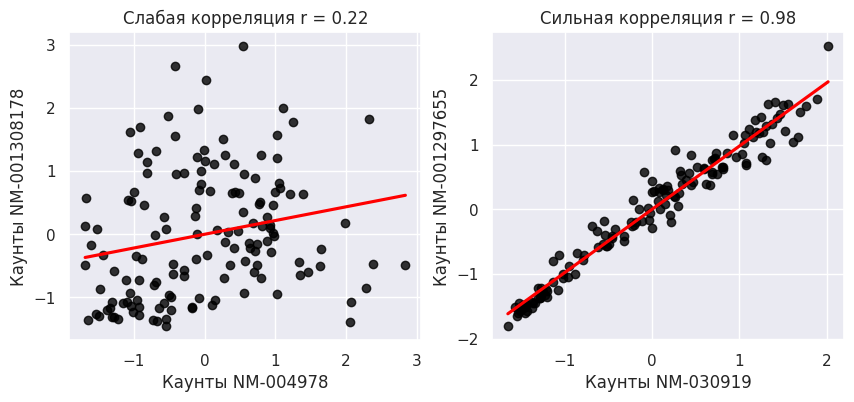

In [7]:
plt.figure(figsize=(10, 4))

# Отобразим зависимость между значениями двух слабокоррелирующих признаков
plt.subplot(1, 2, 1)
sns.regplot(x=X["NM-004978"], y=X["NM-001308178"],
            scatter_kws={"color": "black"}, line_kws={"color": "red"}, ci=None)

plt.xlabel("Каунты NM-004978")
plt.ylabel("Каунты NM-001308178")

weak_corr = np.corrcoef(X["NM-004978"], X["NM-001308178"])[0, 1]
plt.title(f"Слабая корреляция r = {weak_corr:.2f}")

# Отобразим зависимость между значениями двух сильнокоррелирующих признаков
plt.subplot(1, 2, 2)
sns.regplot(x=X["NM-030919"], y=X["NM-001297655"],
            scatter_kws={"color": "black"}, line_kws={"color": "red"}, ci=None)

plt.xlabel("Каунты NM-030919")
plt.ylabel("Каунты NM-001297655")

strong_corr = np.corrcoef(X["NM-030919"], X["NM-001297655"])[0, 1]
plt.title(f"Сильная корреляция r = {strong_corr:.2f}");

Удобнее всего отобразить коэффициенты корреляции в виде матрицы. В библиотеке `seaborn` для её визуализации есть функция [`heatmap`](https://seaborn.pydata.org/generated/seaborn.heatmap.html):

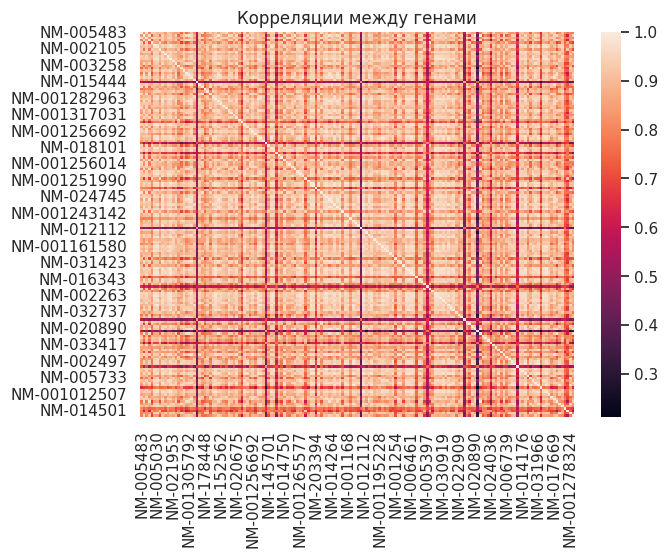

In [8]:
# Считаем корреляции между генами и визуализируем что получилось
plt.figure(figsize=(7, 5))
sns.heatmap(X_train.corr()).set(title="Корреляции между генами");

Видно, что значения корреляций на обоих графиках очень высокие (где-то больше 0,8). Чтобы еще четче это увидеть, воспользуемся функцией [sns.clustermap](https://seaborn.pydata.org/generated/seaborn.clustermap.html), которая кластеризует/сортирует данные для лучшей визуализации.

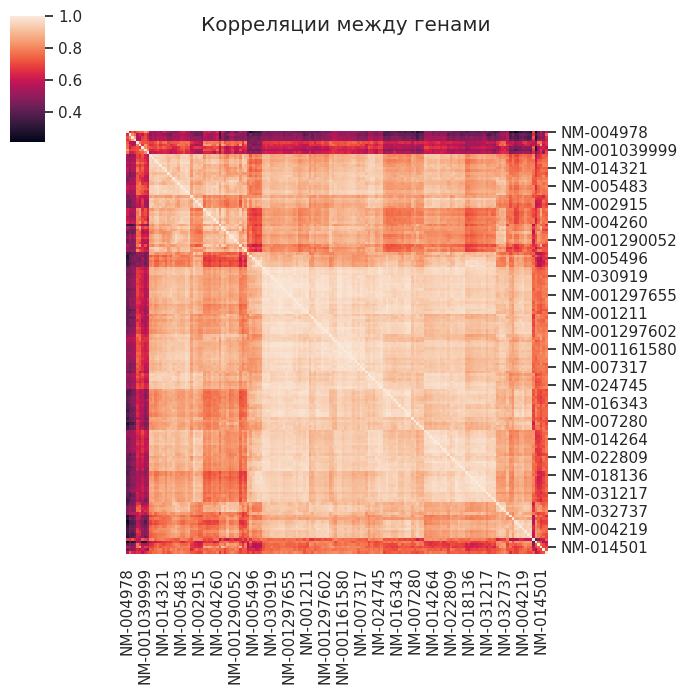

In [9]:
pearson_clusters = sns.clustermap(X_train.corr(), figsize=(7, 7))

pearson_clusters.ax_row_dendrogram.set_visible(False) # Уберем дендрограммы
pearson_clusters.ax_col_dendrogram.set_visible(False)
pearson_clusters.figure.suptitle("Корреляции между генами");

Светлый цвет соответствует сильной корреляции. Видно, что среди признаков много линейно-зависимых. Это довольно типично для bulk RNA-seq, поскольку число генов обычно много больше числа образцов. Посмотрим, как выглядят зависимости между значениями сильно- и слабокоррелирующих признаков.

  ### 2.3 Коэффициент инфляции дисперсии (VIF)

Другим способом продемонстрировать мультиколлинеарность является коэффициент VIF ([Variance Inflation Factor](https://en.wikipedia.org/wiki/Variance_inflation_factor#cite_note-1)). Будем строить линейную модель, используя в качестве целевой переменной один из признаков, а остальные в качестве независимых переменных. Таким образом, мы проверяем, существует ли между признаками линейная зависимость. Метрика определяется следующим образом: $$VIF_i = \frac{1}{1 - R_i^2},$$ где $R_i^2$ &mdash; это значение $R^2$ для линейной регрессии i-го признака по остальным.
Считается, что
1.  VIF = 1 &mdash; переменные не коррелируют;
2.  1 < VIF < 10 &mdash; переменные коррелируют частично
3.  VIF > 10 &mdash; переменные коррелируют очень сильно.

&#x2754; Чему равны соответствующие $R^2$ ?
>&#x1F4A1;
1. $R^2 = 0$
2. $0 < R^2 < 0.9$;
3. $R^2 > 0.9$

Реализуем функцию для подсчёта этой величины:

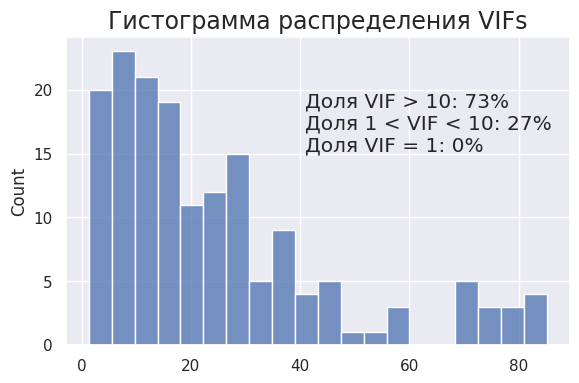

In [10]:
genes = X_train.columns.to_list() # Создаем список всех генов из нашей таблички
VIFs = np.array([]) # Список, в котором мы будем хранить значения VIF для каждого гена

for gene in genes:
    X_VIF, y_VIF = X_train.drop(gene, axis=1), X_train[gene]

    # Не пользуемся данными теста (X_test, y_test), так как мы исследуем свойства нашего датасета, а не подгоняемся под него
    X_train_VIF, X_test_VIF, y_train_VIF, y_test_VIF = train_test_split(X_VIF, y_VIF, test_size=0.2, train_size=0.8, random_state=42)

    model_VIF = LinearRegression()
    model_VIF.fit(X_train_VIF, y_train_VIF)

    r2 = r2_score(y_test_VIF, model_VIF.predict(X_test_VIF))

    VIFs = np.append(VIFs, 1 / (1 - r2))

# Посчитаем долю (в %) генов по пороговым значениями
VIFs_high_ratio = round((VIFs > 10).sum() / VIFs.shape[0], 2) * 100
VIFs_moderate_ratio = round(((VIFs > 1) & (VIFs < 10)).sum() / VIFs.shape[0], 2) * 100
VIFs_no_ratio = round((VIFs == 1).sum() / VIFs.shape[0], 2) * 100

# Визуализируем наши результаты
plt.figure(figsize=(6.5, 4))

hist = sns.histplot(VIFs, bins=20)
hist.axes.set_title("Гистограмма распределения VIFs", fontsize=17)
plt.annotate(f"Доля VIF > 10: {VIFs_high_ratio:.0f}% \nДоля 1 < VIF < 10: {VIFs_moderate_ratio:.0f}% \nДоля VIF = 1: {VIFs_no_ratio:.0f}%", xy=(0.475, 0.63), xycoords='axes fraction',
             fontsize=14.5);

<style>
   .semi {
    opacity: 0.6; /* Полупрозрачность элемента */
    font-size: 11.5pt;
   }
</style>

<div class="semi">

В нашем случае мы получаем очень большие VIF, что означает наличие значительной корреляции между признаками в датасете.

</div>

## 3. Как бороться с мультиколлинеарностью?

### 3.1 Убрать скоррелированные признаки
Можно, например, удалять признаки, для которых VIF принимает большие значения. При этом после каждого удаления необходимо пересчитывать VIF, и уже на основе обновлённых значений делать следующее удаление.

Такой подход может быть полезен в тех случаях, когда признаков чрезвычайно много (например, 100 и более), а ручной отбор не представляется возможным или занимает много времени.

На практике, как правило, используют другие методы борьбы с мультиколлинеарностью:

1.   Регуляризация
2.   Преобразование признакового пространства
3.   Отбор признаков

К линейным моделям эффективнее и проще применять *регуляризацию*, которую далее и рассмотрим.


### 3.2 Регуляризация

>####  Краткое напоминание
Метод подразумевает под собой некую модификацию линейной модели, которая добавляет к функционалу ошибки штраф за слишком большие значения коэффициентов. Это помогает справиться с мультиколлинеарностью, стабилизируя модель и улучшая её обобщающую способность. В задаче линейной регрессии наиболее часто используют модели
 [Ridge](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html), [Lasso](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html) и [ElasticNet](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html).
* **Ridge** &mdash; это модель линейной регрессии с $L_2$-регуляризацией, которая минимизирует функционал\
$$
    \lVert Y - X \theta\rVert^2_2 + \alpha  \lVert\theta\rVert^2_2 → \min_\theta
$$
Здесь $\underset{n\times 1}{Y}$ &mdash; истинные значения целевой переменной, $\underset{n\times d}{X}$ &mdash; матрица "объект-признак", $\underset{d\times 1}{\theta}$ &mdash; коэффициенты модели. Параметр регуляризации $\alpha \geq 0$ управляет силой штрафа. Является **гиперпараметром**, т.е. задаётся пользователем.
* **Lasso** &mdash; модель линейной регрессии с $L_1$-регуляризацией. Минимизирует функционал\
$$
    \lVert Y - X \theta\rVert^2_2 + \alpha  \lVert\theta\rVert_1 → \min_\theta
$$
* **ElasticNet** &mdash; компромисс между двумя предыдущими. Минимизирует функционал\
$$
    \lVert Y - X\theta\rVert^2_2 + \alpha_1  \lVert\theta\rVert_1 + \alpha_2  \lVert\theta\rVert^2_2 → \min_\theta
$$

Теперь рассмотрим все варианты регуляризации и поймем, как значения гиперпараметров влияют на результат.

####  Стандартизация (=нормализация)
Перед тем как пользоваться этими моделями наши данные нужно сначала преобразовать. Регуляризация использует в своей реализации значения коэффициентов модели, а значит, они должны быть сопоставимы между собой, иметь одинаковый масштаб. Для этого воспользуемся классом [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html), который из каждого значения признака (то есть по столбцам в нашем случае) вычитает его среднее значение по всем образцам и потом делит на среднеквадратичное отклонение. Это позволяет убедиться, что все признаки имеют среднее и дисперсию равные 0 и 1, соответственно.

Также на практике часто пользуются другой нормализацией &mdash; [MinMaxscaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html), которая позволяет перевести все значения переменной в фиксированный диапазон, к примеру, [0, 1] или [-1, 1]. Однако сейчас нам она не нужна.

$$StandardScaler: x_{ij}' = \frac{x_{ij} - \mu_j}{S_j};$$

$$MinMaxScaler: x_{ij}' = \frac{x_{ij} - m_j}{M_j - m_j},$$
где $x_{ij}$ и $x_{ij}'$ &mdash; значения признака $j$ для объекта $i$ до и после стандартизации, $\mu_j$ &mdash; выборочное среднее значение признака $j$, $S^2_j$ &mdash;  его выборочная дисперсия, $m_j$ и $M_j$ &mdash; минимальное и максимальное значения признака j по всем объектам.

In [11]:
scaler = StandardScaler()

# Нормируем train и test. Не забываем, что нельзя применять
# метод fit для тестовой выборки, чтобы модель ничего не знала о тестовых данных.
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)   # писать .fit_transform(X_test) КАТЕГОРИЧЕСКИ запрещается

Теперь рассмотрим все варианты регуляризации и поймем, как значения гиперпараметров влияют на качество результатов.

## Практика


#### 3.1 Ridge-регрессия

Создадим модель Ridge-регрессии:

In [12]:
model_ridge = Ridge(
    # коэффициент регуляризации, чем больше - тем сильнее регуляризация (default = 1.0)
    alpha=1.0,

    # использовать ли параметр-остаток при обучении (default = True)
    fit_intercept=True,
)

Обучите эту модель:

In [13]:
model_ridge.fit(X_train, y_train)

Ridge()

Выведите первые двадцать коэффициентов модели:

In [14]:
model_ridge.coef_[:20]

array([ 0.78645761,  1.30597044,  6.96048722, -3.07844368, -1.99856178,
        1.27732251,  3.86768865,  2.18830576, -6.90246306, -5.23283179,
       -2.36982717, 12.992607  ,  5.76717875,  1.90672727, -1.9983426 ,
        2.95168298,  6.16614571,  6.12126098,  1.34045585,  0.63549361])

Выведите значение свободного параметра:

In [15]:
model_ridge.intercept_

45.271929824561404

Выведите настройки модели, использованные при обучении, при помощи метода `get_params`:

In [16]:
model_ridge.get_params()

{'alpha': 1.0,
 'copy_X': True,
 'fit_intercept': True,
 'max_iter': None,
 'positive': False,
 'random_state': None,
 'solver': 'auto',
 'tol': 0.0001}

Сделайте предсказания модели по `X_test` и посчитайте метрики $R^2$ и MAPE.

In [17]:
y_pred_ridge = model_ridge.predict(X_test)

print(f'R2: {round(r2_score(y_test, y_pred_ridge), 2)} \nMAPE: {round(mean_absolute_percentage_error(y_test, y_pred_ridge), 2)}')

R2: 0.71 
MAPE: 0.85


Теперь создадим функцию для визуализации наших результатов, чтобы проследить, как меняются предсказания в зависимости от параметров моделей.

In [18]:
# на этапе выполнения семинара в данный код можно не смотреть

def linear_predictor(alpha, model, count_of_objects=20):
    """Данная функция строит график предсказаний модели
    на первых count_of_objects объектах датасета.

    :param alpha: коэффициент регуляризации
    :param model: тип модели
    """
    # Выберем тип модели
    if model == 'Ridge':
        model = Ridge(alpha=alpha, fit_intercept=True, max_iter=100, tol=0.0001)
    elif model == 'Lasso':
        # см. ниже по ноутбуку
        model = Lasso(alpha=alpha, fit_intercept=True, max_iter=100, tol=0.0001)
    elif model == 'Elastic':
        # см. ниже по ноутбуку
        model = ElasticNet(alpha=alpha, fit_intercept=True, max_iter=100, tol=0.0001)

    # Обучим модель и посчитаем ее предсказания
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Отобразим истинные значения таргета и предсказанные нашей моделью
    plt.figure(figsize=(14, 5))

    plt.scatter(np.arange(count_of_objects), y_pred[:count_of_objects],
              color='#0066FF', label='Предсказания модели')
    plt.plot(np.arange(count_of_objects), y_pred[:count_of_objects],
          color='#0066FF')
    plt.scatter(np.arange(count_of_objects), y_test[:count_of_objects],
                color='#FF3300', label='Истинные значения')

    plt.grid(ls=':')
    plt.xlabel('Номер объекта', fontsize=19)
    plt.xticks(np.arange(count_of_objects))
    plt.ylabel('Предсказание', fontsize=19)
    plt.title('Предсказания на {} объектах'.format(count_of_objects),
              fontsize=22)
    plt.legend(fontsize=19)
    plt.show()

In [19]:
import ipywidgets as widgets

# Создадим виджет, но не будем отображать его
ip = widgets.interactive(
    linear_predictor,
    alpha=widgets.FloatSlider(min=0.0001, max=2, step=0.01, value=1),
    model='Ridge'
);

# Выведем слайдер для изменения параметров модели
display(widgets.HBox(ip.children[:1]))

# Отобразим вывод функции
display(ip.children[-1])
ip.update() # Запуск функции до первого изменения слайдеров

Output()

Сделайте выводы о роли параметра в Ridge-регрессии.

**Выводы:** В зависимости от параметра альфа картинка существенно меняется. При значении около 0.1 можно видеть, что предсказания, в среднем, наиболее близки к истине. При увеличении параметра альфа картинка сжимается.

#### 3.2 Lasso-регрессия

Создадим модель Lasso-регрессии:

In [20]:
model_lasso = Lasso(
    # коэффициент регуляризации, чем больше - тем сильнее регуляризация (default = 1.0)
    alpha=1.0,

    # использовать ли параметр-остаток при обучении (default = True)
    fit_intercept=True,

    # максимальное количество итераций в методе оптимизации (default = 1000)
    max_iter=1000,

    # точность решения (не забываем, что Lasso использует итеративные методы решения)
    # чем значение меньше, тем больше может потребоваться итераций (default = 1e-4)
    tol=0.0001,

    # использовать ли предпосчитанную матрицу Грамма для ускорения расчетов (default = False)
    precompute=True
)

Обучите эту модель:

In [21]:
model_lasso.fit(X_train, y_train)

Lasso(precompute=True)

Выведите первые двадцать коэффициентов модели:

In [22]:
model_lasso.coef_[:20]

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
       -0.        , -0.        ,  0.        , -0.        , -0.        ,
        0.        , -0.        ,  0.        ,  0.        , -7.85609647,
       -0.        , -0.        ,  0.        ,  0.        ,  0.        ])

Выведите значение свободного параметра (intercept):

In [23]:
model_lasso.intercept_

45.271929824561404

&#x2753; **Вопрос** &#x2753;

> Вместо обычного списка коэффициентов Lasso хранит в себе их [разреженное представление](https://python-school.ru/blog/python/sparse-matrix/), то есть только ненулевые элементы. Почему?





**Ответ:** Метод Lasso производит отбор признаков, поэтому возможно нулевые коэффициенты не будут иметь значения, так что память можно сэкономить

Напечатайте значение этого объекта, которое хранится в `sparse_coef_`:

In [24]:
print(model_lasso.sparse_coef_)

  (0, 14)	-7.856096469537857
  (0, 38)	-7.834780554165615
  (0, 43)	2.8254487630787657
  (0, 51)	-11.62305202072054
  (0, 66)	1.6681246130882668
  (0, 104)	-2.1340082049525284
  (0, 108)	4.2365730721561885
  (0, 120)	5.684247447780668
  (0, 122)	5.053883231173427
  (0, 132)	4.7247296339702105
  (0, 136)	-4.372801621293803
  (0, 155)	0.48775555093456086
  (0, 158)	-12.778303626557845
  (0, 159)	2.543678067167823
  (0, 161)	7.878557092019832
  (0, 163)	2.398955259189627


Сделайте предсказания модели по `X_test` и посчитайте метрики $R^2$ и MAPE.

In [35]:
y_pred_lasso = model_lasso.predict(X_test)

print(f'R2: {round(r2_score(y_test, y_pred_lasso), 2)} \nMAPE: {round(mean_absolute_percentage_error(y_test, y_pred_lasso), 2)}')

R2: 0.67 
MAPE: 0.91


Визуализируем данные аналогично примеру с Ridge-регрессией

In [36]:
# Создадим виджет, но не будем отображать его
ip = widgets.interactive(
    linear_predictor,
    alpha=widgets.FloatSlider(min=0.0001, max=15, step=0.1, value=1),
    model='Lasso'
);

# Выведем слайдер для изменения параметров модели
display(widgets.HBox(ip.children[:1]))

# Отобразим вывод функции
display(ip.children[-1])
ip.update() # Запуск функции до первого изменения слайдеров

Output()

Сделайте выводы о роли параметра в Lasso-регрессии.

**Выводы:** В зависимости от параметра альфа картинка существенно меняется. При значении около 0.1 можно видеть, что предсказания, в среднем, наиболее близки к истине. При увеличении параметра альфа кривая спрямляется причём быстрее, чем в прошлом случае

#### 3.3 Elastic-регрессия

Теперь разберемся аналогично с ElasticNet.

In [37]:
model_elastic = ElasticNet(
    # коэффициент регуляризации, чем больше - тем сильнее регуляризация (default = 1.0)
    alpha=0.01,

    # какой регуляризации отдавать предпочтение: l1, а не l2 (default = 0.5)
    l1_ratio=0.6,

    # использовать ли параметр-остаток при обучении (default = True)
    fit_intercept=True,

    # максимальное количество итераций в методе оптимизации (default = 1000)
    max_iter=5000,

    # точность решения,
    # чем значение меньше, тем больше может потребоваться итераций (default = 1e-4)
    tol=0.0001,

    # использовать ли предпосчитанную матрицу Грамма для ускорения расчетов (default = False)
    precompute=True
)

Вот так выглядит связь между `alpha`, `l1_ratio` и $\alpha_1, \alpha_2$, которые мы вводили:

$$
\verb|alpha| = \alpha_1 + 2\alpha_2 \cdot
\\
\verb|l1_ratio| = \frac{\alpha_1}{\alpha_1 + 2\alpha_2}
\\
\alpha_1 = \verb|alpha| \cdot \verb|l1_ratio|\cdot
\\
\alpha_2 = \frac{1}{2} \verb|alpha| \cdot (1 - \verb|l1_ratio|)
$$

Обучите модель.

In [38]:
model_elastic.fit(X_train, y_train)

ElasticNet(alpha=0.01, l1_ratio=0.6, max_iter=5000, precompute=True)

Выведите первые двадцать коэффициентов модели и значение свободного параметра (intercept).

In [39]:
model_elastic.coef_[:20]

array([  0.        ,   2.36725558,   7.64630128,  -2.73750029,
        -3.56906058,   0.33395054,   4.22567732,   2.77045758,
       -11.47295796,  -6.41767817,  -2.56053983,  19.94974819,
         5.52326416,   1.30653461,   0.        ,   3.75281586,
         9.52786042,   5.94723451,   0.16515342,   0.        ])

In [40]:
model_elastic.intercept_

45.271929824561404

Напечатайте, как выглядит разреженное представление коэффициентов.

&#x2753; **Вопрос** &#x2753;
>Есть ли разница по сравнению с Lasso? Почему?

In [41]:
print(model_elastic.sparse_coef_)

  (0, 1)	2.3672555796929453
  (0, 2)	7.646301278053798
  (0, 3)	-2.7375002908262487
  (0, 4)	-3.5690605846451584
  (0, 5)	0.3339505367570471
  (0, 6)	4.22567731982995
  (0, 7)	2.7704575766506494
  (0, 8)	-11.472957958597624
  (0, 9)	-6.417678167678154
  (0, 10)	-2.5605398281883174
  (0, 11)	19.94974819391123
  (0, 12)	5.523264160080089
  (0, 13)	1.3065346114125245
  (0, 15)	3.7528158647046106
  (0, 16)	9.527860424908003
  (0, 17)	5.94723451020217
  (0, 18)	0.16515342105870762
  (0, 20)	-2.015841383453314
  (0, 21)	3.057995276244249
  (0, 22)	3.071180377630002
  (0, 23)	-2.3706889765485903
  (0, 24)	10.640550593340928
  (0, 25)	-3.478427433893222
  (0, 27)	2.2526640549119574
  (0, 28)	-18.029347165185545
  :	:
  (0, 138)	8.62715060190949
  (0, 139)	-1.2884854079562604
  (0, 140)	-3.6720371753226106
  (0, 141)	-7.414480761603549
  (0, 142)	-5.569349822630522
  (0, 144)	-3.967027126328985
  (0, 145)	-13.621944631762865
  (0, 146)	-11.302718973646593
  (0, 147)	-3.3141764211836575
  (0, 14

[Текст ссылки](https://)**Ответ:** Потому что в отличие от Lasso тут не зануляются многие признаки

Сделайте предсказания модели по `X_test` и посчитайте метрики $R^2$ и MAPE:

In [43]:
y_pred_elastic = model_elastic.predict(X_test)

print(f'R2: {round(r2_score(y_test, y_pred_elastic), 2)} \nMAPE: {round(mean_absolute_percentage_error(y_test, y_pred_elastic), 2)}')

R2: 0.64 
MAPE: 1.01


#### 3.4 Сравнение моделей

Сделайте выводы. В чем отличие моделей друг от друга? Также сравните между собой линейную и регуляризованные модели для датасета по РНК-секвенированию.

**Выводы:** В данном семинаре мы использовали три вида регрессии. Можно привести следующие отличия:

- В них используется различная регуляризация L2 - для ridge, L1 - для lasso и L1+L2 в elastic
- Отбор признаков в lasso и elastic, а в ridge отбор признаков не производится
- Разреженное представление только в lasso и elastic

Если рассматривать датасет с РНК-секвенированием, то становится видна разница:
- Линейная модель не справляется с мультиколлинеарностью (у нас очень много признаков, так что такое часто происходит)
- А вот регуляризованная модель показывает результат намного лучше.